# Verifications on Miner modifications

## Imports

In [1]:

# Imports

from itertools import pairwise
from typing import Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rfcnt
import scipy as scs
from numpy.typing import ArrayLike

# %matplotlib widget

## Formulas

In [2]:
# Stationary Gaussian load

def generate_excitation_psd(T=60.0, dt=0.01, S0=16e-6, f0=0.1, w=2.0, seed=None, normalize=True):
    """
    Generate a stationary Gaussian load time series simulating mechanical excitation
    from road surface irregularities using a power spectral density (PSD) model.

    Parameters
    ----------
    T : float
        Total duration of the time series in seconds.
    dt : float
        Time step (sampling interval) in seconds.
    S0 : float
        PSD value at reference frequency f0 [units: m^2/Hz].
    f0 : float
        Reference frequency in Hz (commonly 0.1 Hz for ISO road spectra).
    w : float
        Spectral exponent (typically 2.0 for standard road profiles).
    seed : int or None
        Random seed for reproducibility (default: None).
    normalize : bool
        If True, the resulting signal is zero-mean and unit standard deviation.

    Returns
    -------
    t : ArrayLike
        Time vector (1D array).
    x : ArrayLike
        Simulated load time series (1D array).
    """
    # Number of time points
    N = int(T / dt)
    t = np.arange(0, T, dt)

    # Frequency resolution and frequency axis (one-sided)
    df = 1 / T
    f = np.fft.rfftfreq(N, dt)

    # Power Spectral Density: ISO-like road excitation model
    with np.errstate(divide="ignore"):
        S_f = S0 * (f / f0) ** (-w)
    S_f[0] = 0  # Set DC component to zero (remove offset)

    # Generate random phases
    if seed is not None:
        np.random.seed(seed)
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(f)))

    # Generate frequency-domain signal with desired amplitude spectrum
    amplitudes = np.sqrt(2 * S_f * df)
    X_f = amplitudes * random_phases

    # Inverse FFT to get time-domain signal (real part only)
    x = np.fft.irfft(X_f, n=N)

    # Normalize (optional)
    if normalize:
        x -= np.mean(x)
        x /= np.std(x)

    return t, x

In [3]:
# Damage calculation using 4-point algorithm

def miner_turning_points_damage(
    tp: ArrayLike,
    *,
    cc: int, cw: float, co: float,
    wl_sd: float, wl_nd: float, wl_k: float, wl_k2: Union[float, None] = None,
    q: Union[float, None] = None,
) -> float:
    """
    Computes cumulative fatigue damage using a simplified Miner's rule approach
    with cycle ranges binned from turning points and linear damage accumulation.

    Parameters
    ----------
    tp : ArrayLike
        Sequence of turning point values.
    cc : int
        Number of bins (classes) in the histogram.
    cw : float
        Class width for binning cycle ranges.
    co : float
        Class offset (start of bin range).
    wl_sd : float
        Fatigue strength at 1 cycle (stress amplitude).
    wl_nd : float
        Number of cycles to failure at wl_sd.
    wl_k : float
        S-N curve exponent (material parameter).
    wl_k2 : float | None
        Optional steeper slope below `wl_sd` (Haibach method), defaults to None (leading to Miner elementar).
        When set to np.inf, the "Miner original" approach is used.
    q : float
        Degradation parameter of fatigue strength.

    Returns
    -------
    float:
        Total estimated fatigue damage.
    """
    assert wl_sd > 0
    assert wl_nd > 0
    assert wl_k > 3
    assert wl_k2 is None or wl_k2 >= wl_k or wl_k2 == 0

    if q is None:
        q = wl_k - 1

    # Step 1: Bin the turning points into cycle classes
    tp = np.asarray(tp)
    bins = np.arange(cc + 1) * cw + co
    tp = np.digitize(tp, bins) - 1  # Bin indices (0-based)

    # Step 2: Calculate damage per cycle class using S-N curve
    with np.errstate(divide="ignore"):
        Ni_k  = (np.arange(cc) * (cw / 2) / wl_sd) ** -abs(wl_k)  * wl_nd  # Cycles to failure for k  (Sa >= Sd)
        Di_k  = 1 / Ni_k   # Damage per cycle for k  (Sa >= Sd)
        if wl_k2 is not None:
            Ni_k2 = (np.arange(cc) * (cw / 2) / wl_sd) ** -abs(wl_k2) * wl_nd  # Cycles to failure for k2  (Sa < Sd)
            Di_k2 = 1 / Ni_k2  # Damage per cycle for k2  (Sa < Sd)

    # Step 3: 4-point rainflow cycle counting with linear stack
    D_sum = 0.0
    stack = []
    for point in tp:
        stack.append(point)
        while len(stack) >= 4:
            A, B, C, D = stack[-4:]

            # Normalize ordering to detect closed hysteresis loops
            if A > D:
                A, D = D, A
            if B > C:
                B, C = C, B

            # Check for a closed cycle
            if A <= B and C <= D:
                range_index = C - B
                assert 0 <= range_index < cc
                sa = range_index * cw / 2
                if wl_k2 is None:
                    D_sum += Di_k[range_index]  # Add damage for full cycle
                elif wl_k2 > 0:
                    D_sum += Di_k[range_index] if sa >= wl_sd else Di_k2[range_index]  # Add damage for full cycle
                elif sa >= wl_sd * np.maximum(0, 1 - D_sum) ** (1 / q):
                    D_sum += Di_k[range_index]  # Add damage for full cycle
                # Remove the middle two points (B, C)
                stack.pop(-2)
                stack.pop(-2)
            else:
                break

    return D_sum

In [4]:
# Linear damage accumulation (miner's rule)

def miner_rule_modified(sa: ArrayLike, counts: ArrayLike, wl_sd: float, wl_nd: float, wl_k: float, wl_k2: Union[float, None] = None):
    """
    Calculate total damage using Miner's rule with optional Haibach extension.

    Parameters
    ----------
    sa : ArrayLike
        List or array of stress amplitudes
    counts : ArrayLike
        List or array of number of cycles for each amplitude
    wl_sd : float
        Endurance limit (amplitude)
    wl_nd : float
        Number of cycles at endurance limit (e.g., 1e6)
    wl_k : float
        Slope of the Wöhler curve above `wl_sd`
    wl_k2 : float | None
        Optional steeper slope below `wl_sd` (Haibach method), defaults to None (leading to Miner elementar).
        When set to np.inf, the "Miner original" approach is used.

    Returns
    -------
    total_damage : float
        accumulated (pseudo) damage
    """
    assert wl_k > 0 and (wl_k2 is None or wl_k2 > 0)
    damage = 0.0

    for si, ni in zip(sa, counts):
        if si == 0:
            continue
        if si < wl_sd:
            # Haibach: steeper slope below the knee
            if wl_k2:
                # Miner modified
                k = wl_k2
            else:
                # Miner elementar
                k = wl_k
        else:
            # Standard S-N curve
            k = wl_k

        N = wl_nd * (wl_sd / si) ** k
        d = ni / N
        damage += d

    return damage

In [5]:
# Linear damage accumulation ("consistent Miners's rule")

def miner_rule_consistent(
    sa: ArrayLike,
    counts: ArrayLike,
    *,
    wl_sd: float,
    wl_nd: float,
    wl_k: float,
    sa_bar: ArrayLike,
    inspect: Union[None, int] = None,
):
    """
    Calculate linear damage accumulation using the Miner rule ("consistent Miner's rule" method).

    Parameters
    ----------
    sa : ArrayLike
        Stress amplitudes for each load cycle.
    counts : ArrayLike
        Corresponding number of cycles for each stress amplitude.
    wl_sd : float
        Endurance limit (amplitude)
    wl_nd : float
        Number of cycles at endurance limit (e.g., 1e6)
    wl_k : float
    sa_bar : ArrayLike
        Representative amplitudes at which the damage should be evaluated.
        (Histogram is scaled, so Sa_max falls onto `sa_bar`)
    inspect : int or None, optional
        If an integer is provided, debugging output is printed for the corresponding index.
        If None, no debugging output is shown.

    Returns
    -------
    dict
        Dictionary containing:
            - "A": Distance between Wöhler line and load duration line
            - "D": Damage value according to Haibach
            - "v": Degree of damage utilization
            - "Dm_con": Normalized experimental damage value (FKM-based)
    """
    # Input flattening and validation
    sa = np.ravel(sa)
    counts = np.ravel(counts)
    assert sa.shape == counts.shape, "Stress amplitudes and counts must have the same shape"

    # Remove zero-count entries and sort descending by amplitude
    mask = counts > 0
    sa, counts = sa[mask], counts[mask]
    sort_idx = np.argsort(-sa)
    sa, counts = sa[sort_idx], counts[sort_idx]

    sa1 = sa.max()  # Maximum amplitude
    x = np.append(sa / sa1, 0)  # Normalized amplitude (descending + 0 for integration end)

    h = counts  # Step heights (cycle counts)
    H = np.cumsum(h)  # Cumulative cycles (not directly used here)

    # Wöhler parameters
    sd = wl_sd
    nd = wl_nd
    k = abs(wl_k)
    q = k - 1

    sa_bar = np.ravel(sa_bar if sa_bar is not None else [sa1])
    N_bar = (sa_bar / sd) ** -k * nd  # Cycles to failure for sa_bar

    A = np.zeros_like(sa_bar, dtype=float)       # Damage distance factor
    D_inv = np.zeros_like(sa_bar, dtype=float)   # Inverse damage for check

    for i in range(len(sa_bar)):
        xd = xD = sd / sa_bar[i]

        # Find transition index for relevant x values
        j = np.flatnonzero(x >= xD)
        if len(j) == 0:
            A[i] = D_inv[i] = np.infty
        else:
            j = j[-1]

            for d in range(j + 1, len(x)):
                # Fraction between two adjacent x values
                fraction = (xd / xD) ** q - (x[d] / xD) ** q
                A[i] += fraction * np.sum(h) / np.sum(h[:d] * x[:d] ** k)

                if inspect is not None:
                    Ni = (sa_bar[i] * x[:-1] / sd) ** -k * nd  # Cycles to failure on Wöhler line
                    Dd = np.sum(h[:d] / Ni[:d])
                    D_inv[i] += fraction / Dd

                    if i == inspect:
                        Ai_check = np.sum(h) / N_bar[i] * D_inv[i]
                        print(
                            f"i: {d:<3}  sa_bar: {sa_bar[i]:.3g}  "
                            f"Dd: {Dd:10.3e}  1/Dd: {1/Dd:11.3f}  "
                            f"Ad: {fraction / Dd:10.3f}  "
                            f"Ai_check: {Ai_check:10.3f}  Ai: {A[i]:10.3f}"
                        )

                xd = x[d]  # Update lower integration bound

    D = np.sum(h) / (N_bar * A)

    if inspect is not None:
        i = np.isfinite(A)
        assert np.allclose(D[i] * D_inv[i], 1.0, atol=1e-3), "D * D_inv != 1, check failed"

    # FKM-based damage evaluation
    v = 1 / A ** (1 / k)
    Dm = 2 / A ** 0.25
    Dm = np.clip(Dm, 0.2, 1.0)  # Clip (recommended)

    return {
        "A": A,        # Distance metric
        "D": D,        # Haibach-based damage sum
        "v": v,        # "Völligkeitsmaß"
        "Dm_con": Dm,  # Normalized damage according to FKM
    }

## Verification "Miner consequent"

In [6]:
# Test of the algorithm for comparison with the book
# "Betriebsfestigkeit", Erwin Haibach, 3rd Edition, 2006, Springer,
# Table 3.2-6, p. 309

wl_sd  = 100
wl_nd  = 1e6
wl_k   = 4
q      = wl_k - 1
sa     = [1, 0.95, 0.85, 0.725, 0.575, 0.425, 0.275,  0.125 ]
counts = [2, 16,   280,  2720,  20000, 92000, 280000, 605000]

display(
    pd.DataFrame({
        "h_i": [*counts, ""],
        "x_i": [*[f"{s:.3f}" for s in sa], 0],
        "h_i * x_i^k": [*[f"{v:.3f}" for v in [c * s ** wl_k for c, s in zip(counts, sa)]], ""],
        "sum(h_i * x_i^k)": [*[f"{v:.3f}" for v in np.cumsum([c * s ** wl_k for c, s in zip(counts, sa)])], ""],
        "x_i^q - x_{i+1}^q": [*[f"{v:.6f}" for v in [x0**q - x1**q for x0, x1 in pairwise([*sa, 0])]], ""]
    }, index=pd.Series([*list(range(1, len(counts) + 1)), f"({len(counts) + 1})"], name="i"))
)

result = miner_rule_consistent(
    sa,
    counts,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    sa_bar=[100, 105, 110, 115, 125, 150, 175, 200, 250, 300, 350, 400, 500, 600, 700, 800],
    inspect=1,
)

A = result["A"].round(3)
display(A.tolist())

# Compare with expected results
assert(np.allclose(A, [
    89199.590,
    24445.830,
    14414.850,
    6980.954,
    2089.658,
    556.181,
    253.551,
    219.482,
    152.775,
    144.658,
    133.296,
    129.536,
    129.245,
    128.810,
    128.205,
    127.398,
], rtol=1e-3))


print("Check ok!")

,h_i,x_i,h_i * x_i^k,sum(h_i * x_i^k),x_i^q - x_{i+1}^q
i,,,,,
1,2,1.000,2.000,2.000,0.142625
2,16,0.950,13.032,15.032,0.243250
3,280,0.850,146.162,161.194,0.233047
4,2720,0.725,751.486,912.680,0.190969
5,20000,0.575,2186.258,3098.938,0.113344
6,92000,0.425,3001.536,6100.474,0.055969
7,280000,0.275,1601.359,7701.833,0.018844
8,605000,0.125,147.705,7849.538,0.001953
(9),,0,,,


i: 1    sa_bar: 105  Dd:  2.431e-06  1/Dd:  411351.237  Ad:   3077.428  Ai_check:   3740.700  Ai:   3740.700
i: 2    sa_bar: 105  Dd:  1.827e-05  1/Dd:   54729.710  Ad:  15411.464  Ai_check:  22473.768  Ai:  22473.768
i: 3    sa_bar: 105  Dd:  1.959e-04  1/Dd:    5103.808  Ad:   1376.910  Ai_check:  24147.441  Ai:  24147.441
i: 4    sa_bar: 105  Dd:  1.109e-03  1/Dd:     901.414  Ad:    199.276  Ai_check:  24389.666  Ai:  24389.666
i: 5    sa_bar: 105  Dd:  3.767e-03  1/Dd:     265.479  Ad:     34.833  Ai_check:  24432.007  Ai:  24432.007
i: 6    sa_bar: 105  Dd:  7.415e-03  1/Dd:     134.859  Ad:      8.738  Ai_check:  24442.628  Ai:  24442.628
i: 7    sa_bar: 105  Dd:  9.362e-03  1/Dd:     106.819  Ad:      2.330  Ai_check:  24445.460  Ai:  24445.460
i: 8    sa_bar: 105  Dd:  9.541e-03  1/Dd:     104.809  Ad:      0.237  Ai_check:  24445.748  Ai:  24445.748


[89199.583,
 24445.748,
 14414.851,
 6980.959,
 2089.659,
 556.181,
 253.551,
 219.482,
 152.775,
 144.658,
 133.329,
 129.536,
 129.245,
 128.811,
 128.205,
 127.398]

Check ok!


In [7]:
# Damage value for sa_bar

sa_bar = 105

D = miner_rule_consistent(
    sa,
    counts,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    sa_bar=[sa_bar],
)["D"].item()

print(f"Damage: {D:.6e}")

Damage: 4.972350e-05


In [8]:
# Damage value for sa_bar (rfcnt)

D = rfcnt.rfcnt.damage_from_rp(
    np.array(sa) * sa_bar,
    counts,
    wl={
        "sx": wl_sd,
        "nx": wl_nd,
        "sd": wl_sd,
        "k": wl_k,
    },
    method=rfcnt.RPDamageCalcMethod.MINER_CONSISTENT
)

print(f"Damage: {D:.6e}")

Damage: 4.972350e-05


## Verification with random loads

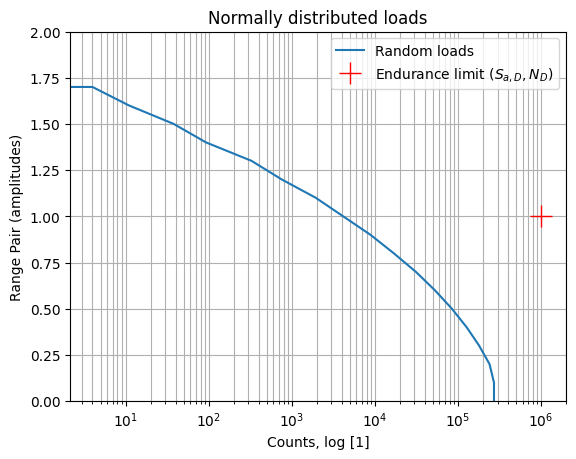

Sa_max: 1.70
Damage (elementar): 2.215891e-02


In [9]:
# Random loads

loads_type = 1
seed       = 42
wl_sd      = 1
wl_nd      = 1e6
wl_k       = 4

scalings = [1.2, 1.8, 1.8]


if loads_type == 0:
    # Stationary uniformly distributed loads
    # (The very full collective ensures a fast continuous decrease in fatigue strength,
    # which is why the signal length is shortened here from 1e6 to 1e5.)
    data = scs.stats.uniform.rvs(loc=-1, scale=2, size=int(1e5), random_state=seed)
elif loads_type == 1:
    # Stationary gaussian distributed loads
    data = scs.stats.norm.rvs(size=int(1e6), random_state=seed)
elif loads_type == 2:
    # Stationary gaussian distributed loads (natural excitation)
    _, data = generate_excitation_psd(T=1e6, dt=1, w=0.1, seed=seed)
else:
    raise RuntimeError

data = data / np.max(np.abs(data)) * scalings[loads_type]
cc = 21
cw = 0.2
co = np.min(data) - cw
wl = {
    "sx": wl_sd,
    "nx": wl_nd,
    "k": wl_k,
    "sd": wl_sd,
}
result = rfcnt.rfc(
    data,
    class_width=cw,
    class_offset=co,
    class_count=cc,
    wl={**wl, "sd": 0},   # if `sx` or `nx` is given, `sd` must be set to zero here, to get miner elementar damage!
    residual_method=rfcnt.ResidualMethod.NONE,
)

sa, counts = (result["rp"][::-1].astype(float) * [0.5, 1]).T
plt.semilogx(np.cumsum(counts), sa, label="Random loads")
plt.plot(wl["nx"], wl["sx"], "r+", ms=16, label="Endurance limit $(S_{a,D}, N_D)$")
plt.ylim(0, 2)
plt.xlim(None, 2e6)
plt.grid(visible=True, which="both")
plt.xlabel("Counts, log [1]")
plt.ylabel("Range Pair (amplitudes)")
plt.title("Normally distributed loads")
plt.legend()
plt.show()

tp = result["tp"].T[1]  # Turning points
sa, counts = (result["rp"][::-1].astype(float) * [0.5, 1]).T
sa_max = sa[np.flatnonzero(counts > 0)[0]]

print(f"Sa_max: {sa_max:.2f}")
print(f"Damage (elementar): {result['damage']:.6e}")

### Miner elementar

In [10]:
# From histogram

D = miner_rule_modified(
    sa,
    counts,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    # Discarding wl_k2 here leads to "Miner elementar"
)

print(f"Damage (elementar): {D:.6e}")

Damage (elementar): 2.215891e-02


In [11]:
# From histogram (rfcnt)

D = rfcnt.damage_from_rp(
    sa,
    counts,
    wl=wl,
    method=rfcnt.RPDamageCalcMethod.MINER_ELEMENTAR
)

print(f"Damage (elementar): {D:.6e}")

Damage (elementar): 2.215891e-02


In [12]:
# From turning points

D = miner_turning_points_damage(
    tp,
    cc=cc, cw=cw, co=co,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    # Discarding wl_k2 here leads to "Miner elementar"
)

print(f"Damage (elementar): {D:.6e}")

Damage (elementar): 2.215891e-02


### Miner modified

In [13]:
# From histogram

D = miner_rule_modified(
    sa,
    counts,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    wl_k2=wl_k * 2 - 1,
)

print(f"Damage (elementar): {D:.6e}")

Damage (elementar): 1.199233e-02


In [14]:
# From histogram (rfcnt)

D = rfcnt.damage_from_rp(
    sa,
    counts,
    wl={**wl, "k2": wl_k * 2 - 1},
    method=rfcnt.RPDamageCalcMethod.MINER_MODIFIED,
)

print(f"Damage (elementar): {D:.6e}")

Damage (elementar): 1.199233e-02


In [15]:
# From timeseries (rfcnt)

result = rfcnt.rfc(
    data,
    class_width=cw,
    class_offset=co,
    class_count=cc,
    wl = {**wl, "sd": 0, "k2": wl_k * 2 - 1},  # `sd` must be set to zero here, to take values less `sx` into account!
    residual_method=rfcnt.ResidualMethod.NONE,
)
D = result["damage"]

print(f"Damage (consistent): {D:.6e}")

Damage (consistent): 1.199233e-02


In [16]:
# From turning points

D = miner_turning_points_damage(
    tp,
    cc=cc, cw=cw, co=co,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    wl_k2=wl_k * 2 -1,
)

print(f"Damage (elementar): {D:.6e}")

Damage (elementar): 1.199233e-02


## Miner original

In [17]:
# From histogram

D = miner_rule_modified(
    sa,
    counts,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    wl_k2=np.inf,
)

print(f"Damage (origial): {D:.6e}")

Damage (origial): 5.947180e-03


In [18]:
# From histogram (rfcnt)

D = rfcnt.damage_from_rp(
    sa,
    counts,
    wl={**wl, "k2": np.inf},
    method=rfcnt.RPDamageCalcMethod.MINER_MODIFIED,
)

print(f"Damage (original): {D:.6e}")

Damage (original): 5.947180e-03


In [19]:
# From timeseries (rfcnt)

result = rfcnt.rfc(
    data,
    class_width=cw,
    class_offset=co,
    class_count=cc,
    wl = {**wl, "sd": 0, "k2": np.inf},  # `sd` must be set to zero here, to take values less `sx` into account!
    residual_method=rfcnt.ResidualMethod.NONE,
)
D = result["damage"]

print(f"Damage (original): {D:.6e}")

Damage (original): 5.947180e-03


In [20]:
# From turning points

D = miner_turning_points_damage(
    tp,
    cc=cc, cw=cw, co=co,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    wl_k2=np.inf,
)

print(f"Damage (original): {D:.6e}")

Damage (original): 5.947180e-03


### Miner consistent

In [21]:
# From histogram

D = miner_rule_consistent(
    sa,
    counts,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    sa_bar=[sa_max]
)["D"].item()

print(f"Damage (consistent): {D:.6e}")

Damage (consistent): 9.787114e-03


In [22]:
# From histogram (rfcnt)

D = rfcnt.damage_from_rp(
    sa,
    counts,
    wl=wl,
    method=rfcnt.RPDamageCalcMethod.MINER_CONSISTENT,
)

print(f"Damage (consistent): {D:.6e}")

Damage (consistent): 9.787114e-03


In [23]:
# From timeseries (rfcnt)

# Since `rfcnt` evaluates the damage according to the current state of the time series and
# considering the order amplitudes, it differs from the Haibach estimate, which refers to a
# histogram that assumes uniform loads over time and a constant N_bar/N ratio for Sa_bar.
# (The equilibrium for both methods is shown later.)

result = rfcnt.rfc(
    data,
    class_width=cw,
    class_offset=co,
    class_count=cc,
    wl = wl,
    residual_method=rfcnt.ResidualMethod.NONE,
)
D = result["wl_miner_consistent"]

print(f"Damage (consistent): {D['D']:.6e}")

Damage (consistent): 5.947180e-03


In [24]:
# From turning points

D = miner_turning_points_damage(
    tp,
    cc=cc, cw=cw, co=co,
    wl_sd=wl_sd,
    wl_nd=wl_nd,
    wl_k=wl_k,
    wl_k2=0,  # `wl_k2`==0  ==> Miner consistent
)

print(f"Damage (consistent): {D:.6e}")

Damage (consistent): 5.947180e-03


## Comparisation of approaches

In [25]:
# Damage results for shifted SN-curve and various Miner rules

results = []
for wl_nd in np.logspace(3, 5, 10):
    D_rp_el_py = miner_rule_modified(
        sa,
        counts,
        wl_sd=wl_sd,
        wl_nd=wl_nd,
        wl_k=wl_k,
    )
    D_rp_mod_py = miner_rule_modified(
        sa,
        counts,
        wl_sd=wl_sd,
        wl_nd=wl_nd,
        wl_k=wl_k,
        wl_k2=wl_k * 2 -1,
    )
    D_rp_py = miner_rule_consistent(
        sa,
        counts,
        wl_sd=wl_sd,
        wl_nd=wl_nd,
        wl_k=wl_k,
        sa_bar=[sa_max],
    )["D"].item()
    D_rp_rfc = rfcnt.damage_from_rp(
        sa,
        counts,
        wl={**wl, "nx": wl_nd, "sd": 1},
        method=rfcnt.RPDamageCalcMethod.MINER_CONSISTENT,
    )
    D_tp_py = miner_turning_points_damage(
        tp,
        cc=cc, cw=cw, co=co,
        wl_sd=wl_sd,
        wl_nd=wl_nd,
        wl_k=wl_k,
        wl_k2=0,
    )
    D_ts_rfc = rfcnt.rfc(
        data,
        class_width=cw,
        class_offset=co,
        class_count=cc,
        wl = {**wl, "nx": wl_nd, "sd": 1, "k2": 4},
        residual_method=rfcnt.ResidualMethod.NONE,
    )["wl_miner_consistent"]
    results.append([wl_nd, D_rp_el_py, D_rp_mod_py, D_rp_py, D_rp_rfc, D_tp_py, D_ts_rfc["D"]])
results = np.array(results)
labels = [
    "$N_D$",
    "Miner elementar (estimate, Python)",
    "Miner modified 2k-1 (estimate, Python)",
    "Miner consistent (estimate, Python)",
    "Miner consistent (estimate, rfcnt)",
    "Miner consistent (truth, Python)",
    "Miner consistent (truth, rfcnt)",
]

Equality for estimate and truth at 9787 cycles (D=1)


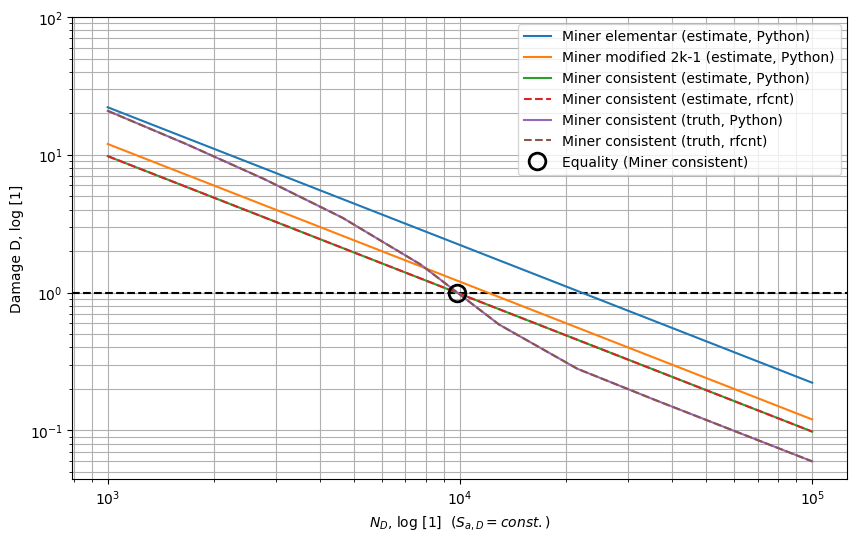

In [26]:
# Plot results

plt.clf()
plt.gcf().set_size_inches(10, 6)
plt.axhline(1, c="k", ls="--")
lines = plt.loglog(results[:, 0], results[:, 1:], label=labels[1:], ls="-")
lines[3].set_ls("--")
lines[5].set_ls("--")
N_eq = results[0, 0] * results[0, 4]  # ND * D
plt.plot(N_eq, 1, "o", c="none", mec="k", ms=12, mew=2, label="Equality (Miner consistent)")
plt.ylim(top=1e2)
plt.grid(visible=True, which="both")
plt.legend()
plt.xlabel("$N_D$, log [1]  $(S_{a,D}=const.)$")
plt.ylabel("Damage D, log [1]")
print(f"Equality for estimate and truth at {N_eq:.0f} cycles (D=1)")
plt.show()

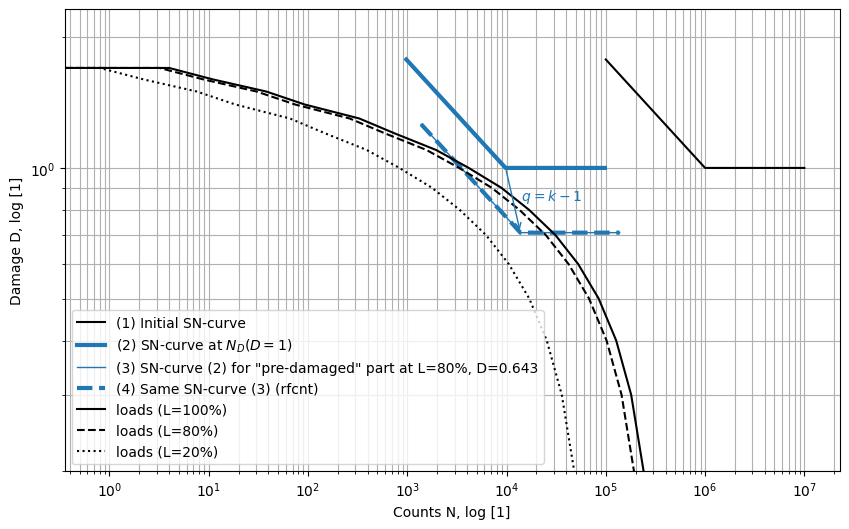

In [ ]:
# Plot SN-curves and loads

# The diagram shows the calculated SN curve according to Miner consistent,
# where the loads lead to a (pseudo) damage sum of D=1.
# The second SN curve is that of the "pre-damaged" component after 80% of the
# loads, which can only withstand the remaining 20%.

# Define three SN-cuve: 1/10th, 1 and 10 times the cycle counts at the equilibrium
wl2 = {**wl, "nx": N_eq, "nd": N_eq}
k = np.array([wl["k"], wl["k"], 1e30])  # three k slopes
xn = np.array([1e-1, 1, 10])  # three cycle count factors
xs = xn ** -(1/k)  # three amplitude factors

# Obtain the "ground truth" SN-curve of a pre-damaged part, by considering
# the closed cycles and(!) their order of occurrence.
rfc_tp = rfcnt.rfc(
    data,
    class_width=cw,
    class_offset=co,
    class_count=cc,
    wl=wl,
    residual_method=rfcnt.ResidualMethod.NONE,
)
rfc_tp_con = rfc_tp["wl_miner_consistent"]

# Do the same for 4/5th (80%) of the loads
rfc_tp2 = rfcnt.rfc(
    data[len(data) // 5:],  # 80% loads
    class_width=cw,
    class_offset=co,
    class_count=cc,
    wl=wl2,
    residual_method=rfcnt.ResidualMethod.NONE,
)
rfc_tp2_con = rfc_tp2["wl_miner_consistent"]

plt.clf()
plt.gcf().set_size_inches(10, 6)
plt.loglog(
    wl["nx"] * xn,
    wl["sx"] * xs,
    "k-",
    label="(1) Initial SN-curve"
)
plt.loglog(
    N_eq * xn,
    wl["sd"] * xs,
    c="tab:blue", ls="-", lw=3,
    label="(2) SN-curve at $N_D(D=1)$"
)
# SN-curve for "pre-damaged" part
D = rfc_tp2_con["D"]
sd = wl["sd"] * (1 - D) ** (1 / q)
nd = N_eq * (1 - D) * (sd / wl["sd"]) ** -wl["k"]
plt.loglog(
    nd * xn,
    sd * xs,
    c="tab:blue", ls="-", lw=1,
    label=f"(3) SN-curve (2) for \"pre-damaged\" part at L=80%, D={rfc_tp2_con['D']:.3f}"
)
# Same curve (taken from rfcnt results)
plt.loglog(
    rfc_tp2_con["nx"] * xn,
    rfc_tp2_con["sx"] * xs,
    c="tab:blue", ls="--", lw=3,
    label="(4) Same SN-curve (3) (rfcnt)"
)
# Annotate SD degradation "q"
plt.annotate("", xy=(nd, sd), xytext=(N_eq, wl["sd"]), arrowprops={"arrowstyle": "->", "color": "tab:blue"})
plt.text(*np.sqrt([nd * N_eq, sd * wl["sd"]]), "  $q=k-1$", c="tab:blue")
# Loads
plt.plot(np.cumsum(counts), sa, "k-", label="loads (L=100%)")
plt.plot(np.cumsum(counts) * 0.8, sa, "k--", label="loads (L=80%)")
plt.plot(np.cumsum(counts) * 0.2, sa, "k:", label="loads (L=20%)")
plt.xlabel("Counts N, log [1]")
plt.ylabel("Damage D, log [1]")
plt.ylim(0.2)
plt.grid(visible=True, which="both")
plt.legend()
plt.show()